In [ ]:
import zipfile

with zipfile.ZipFile('/content/archive (3).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Road_crack')

In [ ]:
from PIL import Image
from skimage.segmentation import mark_boundaries
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
import os
import shutil
import json
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
def show_image(array: np.ndarray) -> Image:
  return Image.fromarray(np.uint8(array))

In [ ]:
def show_segments(image: np.ndarray, segment_mask:np.ndarray) -> Image:
  return show_image(255*mark_boundaries(image,segment_mask))

In [ ]:
train_dataset = image_dataset_from_directory('/content/Road_crack/pr dataset/train',
                                             shuffle=True,
                                             batch_size= 25,
                                             image_size= (224,224),
                                             seed=42)

Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory('/content/Road_crack/pr dataset/valid',
                                             shuffle=True,
                                             batch_size= 25,
                                             image_size= (224,224),
                                             seed=42)

Found 200 files belonging to 2 classes.


In [ ]:
Autotune = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=Autotune)

In [ ]:
def data_augmenter():

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation

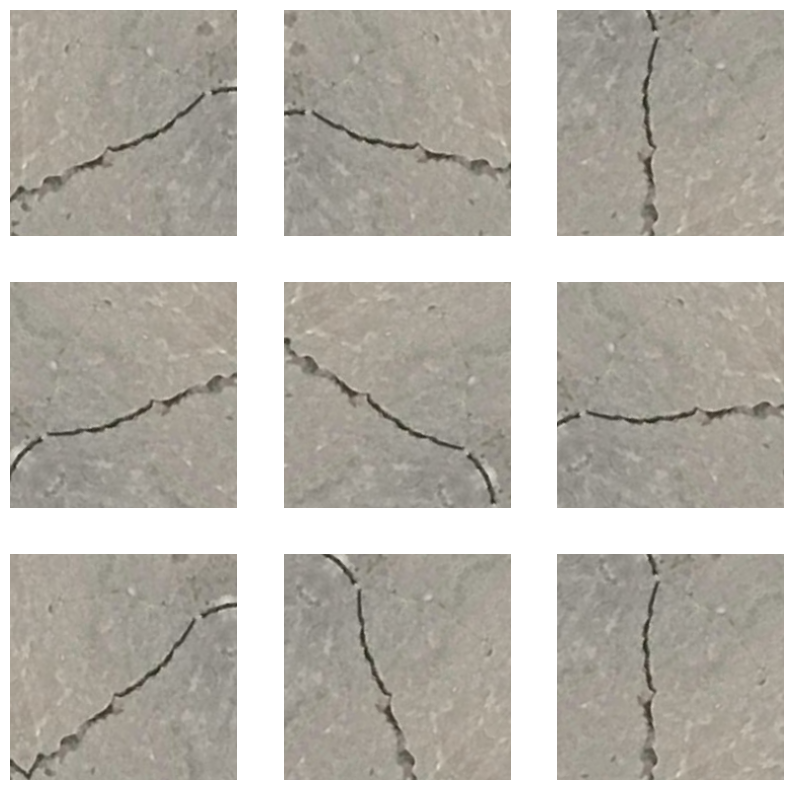

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input_mobileNet = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3),
                                                   include_top = False,
                                                   weights= 'imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = tf.keras.Input(shape = (224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input_mobileNet(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(rate = 0.2)(x)

outputs = layers.Dense(units = 100, activation = 'linear')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
mobileNet_tune = model.layers[4]
mobileNet_tune.trainable = True

In [ ]:
for layer in mobileNet_tune.layers[:100]:
    layer.trainable = False

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(loss = loss_function,
              optimizer = optimizer,
              metrics = ['accuracy'])

In [ ]:
image.shape

TensorShape([25, 224, 224, 3])

In [ ]:
history = model.fit(train_dataset, epochs = 20, validation_data = validation_dataset)

Epoch 1/20
80/80 [==============================] - 26s 76ms/step - loss: 0.4803 - accuracy: 0.9275 - val_loss: 3.3472 - val_accuracy: 0.4750
Epoch 2/20
80/80 [==============================] - 6s 70ms/step - loss: 0.0230 - accuracy: 0.9930 - val_loss: 2.5237 - val_accuracy: 0.6400
Epoch 3/20
80/80 [==============================] - 5s 59ms/step - loss: 0.0178 - accuracy: 0.9950 - val_loss: 1.9147 - val_accuracy: 0.7900
Epoch 4/20
80/80 [==============================] - 5s 63ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.7095 - val_accuracy: 0.9400
Epoch 5/20
80/80 [==============================] - 5s 58ms/step - loss: 0.0227 - accuracy: 0.9935 - val_loss: 0.8396 - val_accuracy: 0.9100
Epoch 6/20
80/80 [==============================] - 5s 59ms/step - loss: 0.0099 - accuracy: 0.9960 - val_loss: 0.3979 - val_accuracy: 0.9500
Epoch 7/20
80/80 [==============================] - 5s 63ms/step - loss: 0.0062 - accuracy: 0.9985 - val_loss: 0.2196 - val_accuracy: 0.9750
Epoch 8/20
8